In [4]:
# loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [5]:
df = pd.read_pickle("./LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [6]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [7]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


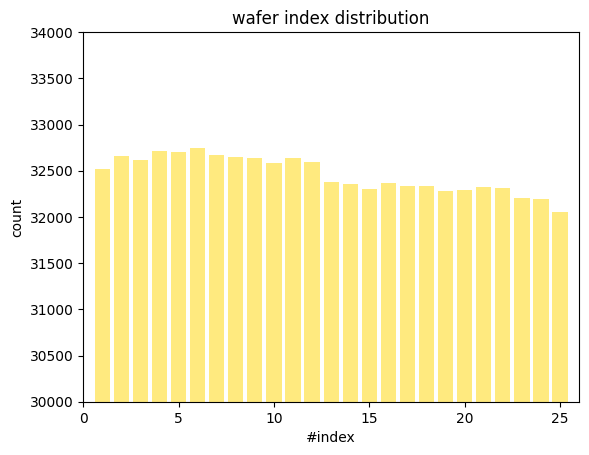

In [8]:
unique_index = np.unique(df.waferIndex, return_counts=True)
plt.bar(unique_index[0], unique_index[1], color='gold', align='center', alpha=0.5)
plt.title('wafer index distribution')
plt.xlabel('#index')
plt.ylabel('count')
plt.xlim(0, 26)
plt.ylim(30000, 34000)
plt.show()

In [9]:
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return (dim0, dim1)

df['waferMapDim'] = df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
400232,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",592.0,lot23955,3.0,[],[],"(29, 27)"
415310,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",15545.0,lot24678,10.0,[],[],"(135, 146)"
484708,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot30021,11.0,[],[],"(33, 33)"
7457,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1724.0,lot1291,7.0,[[Training]],[[none]],"(50, 43)"
438034,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1080.0,lot26475,9.0,[],[],"(35, 40)"


In [10]:
max(df['waferMapDim']), min(df['waferMapDim'])

((300, 202), (6, 21))

In [11]:
unique_waferDim = np.unique(df['waferMapDim'])
unique_waferDim.shape

(632,)

In [12]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel

mapping_type={
    'Center':0,
    'Donut':1,
    'Edge-Loc':2,
    'Edge-Ring':3,
    'Loc':4,
    'Random':5,
    'Scratch':6,
    'Near-full':7,
    'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [13]:
df_label = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_label = df_label.reset_index()
df_pattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_pattern = df_pattern.reset_index()
df_none = df[(df['failureNum']==8)]

df_label.shape[0], df_pattern.shape[0], df_none.shape[0]

(172950, 25519, 147431)

In [14]:
tol_wafers = df.shape[0]
tol_wafers

811457

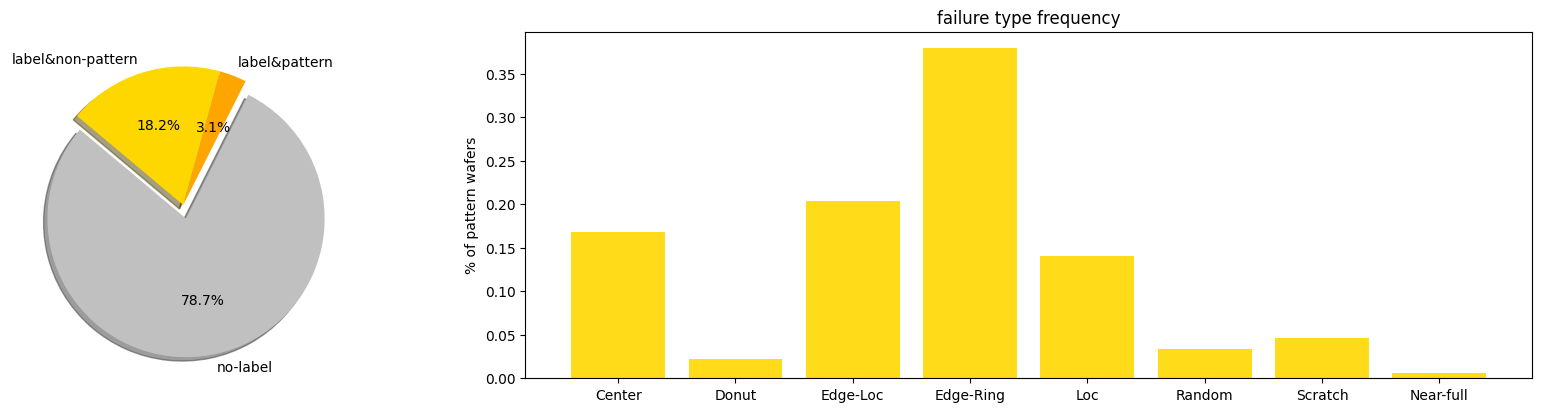

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_label.shape[0], df_pattern.shape[0], df_none.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_pattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_pattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

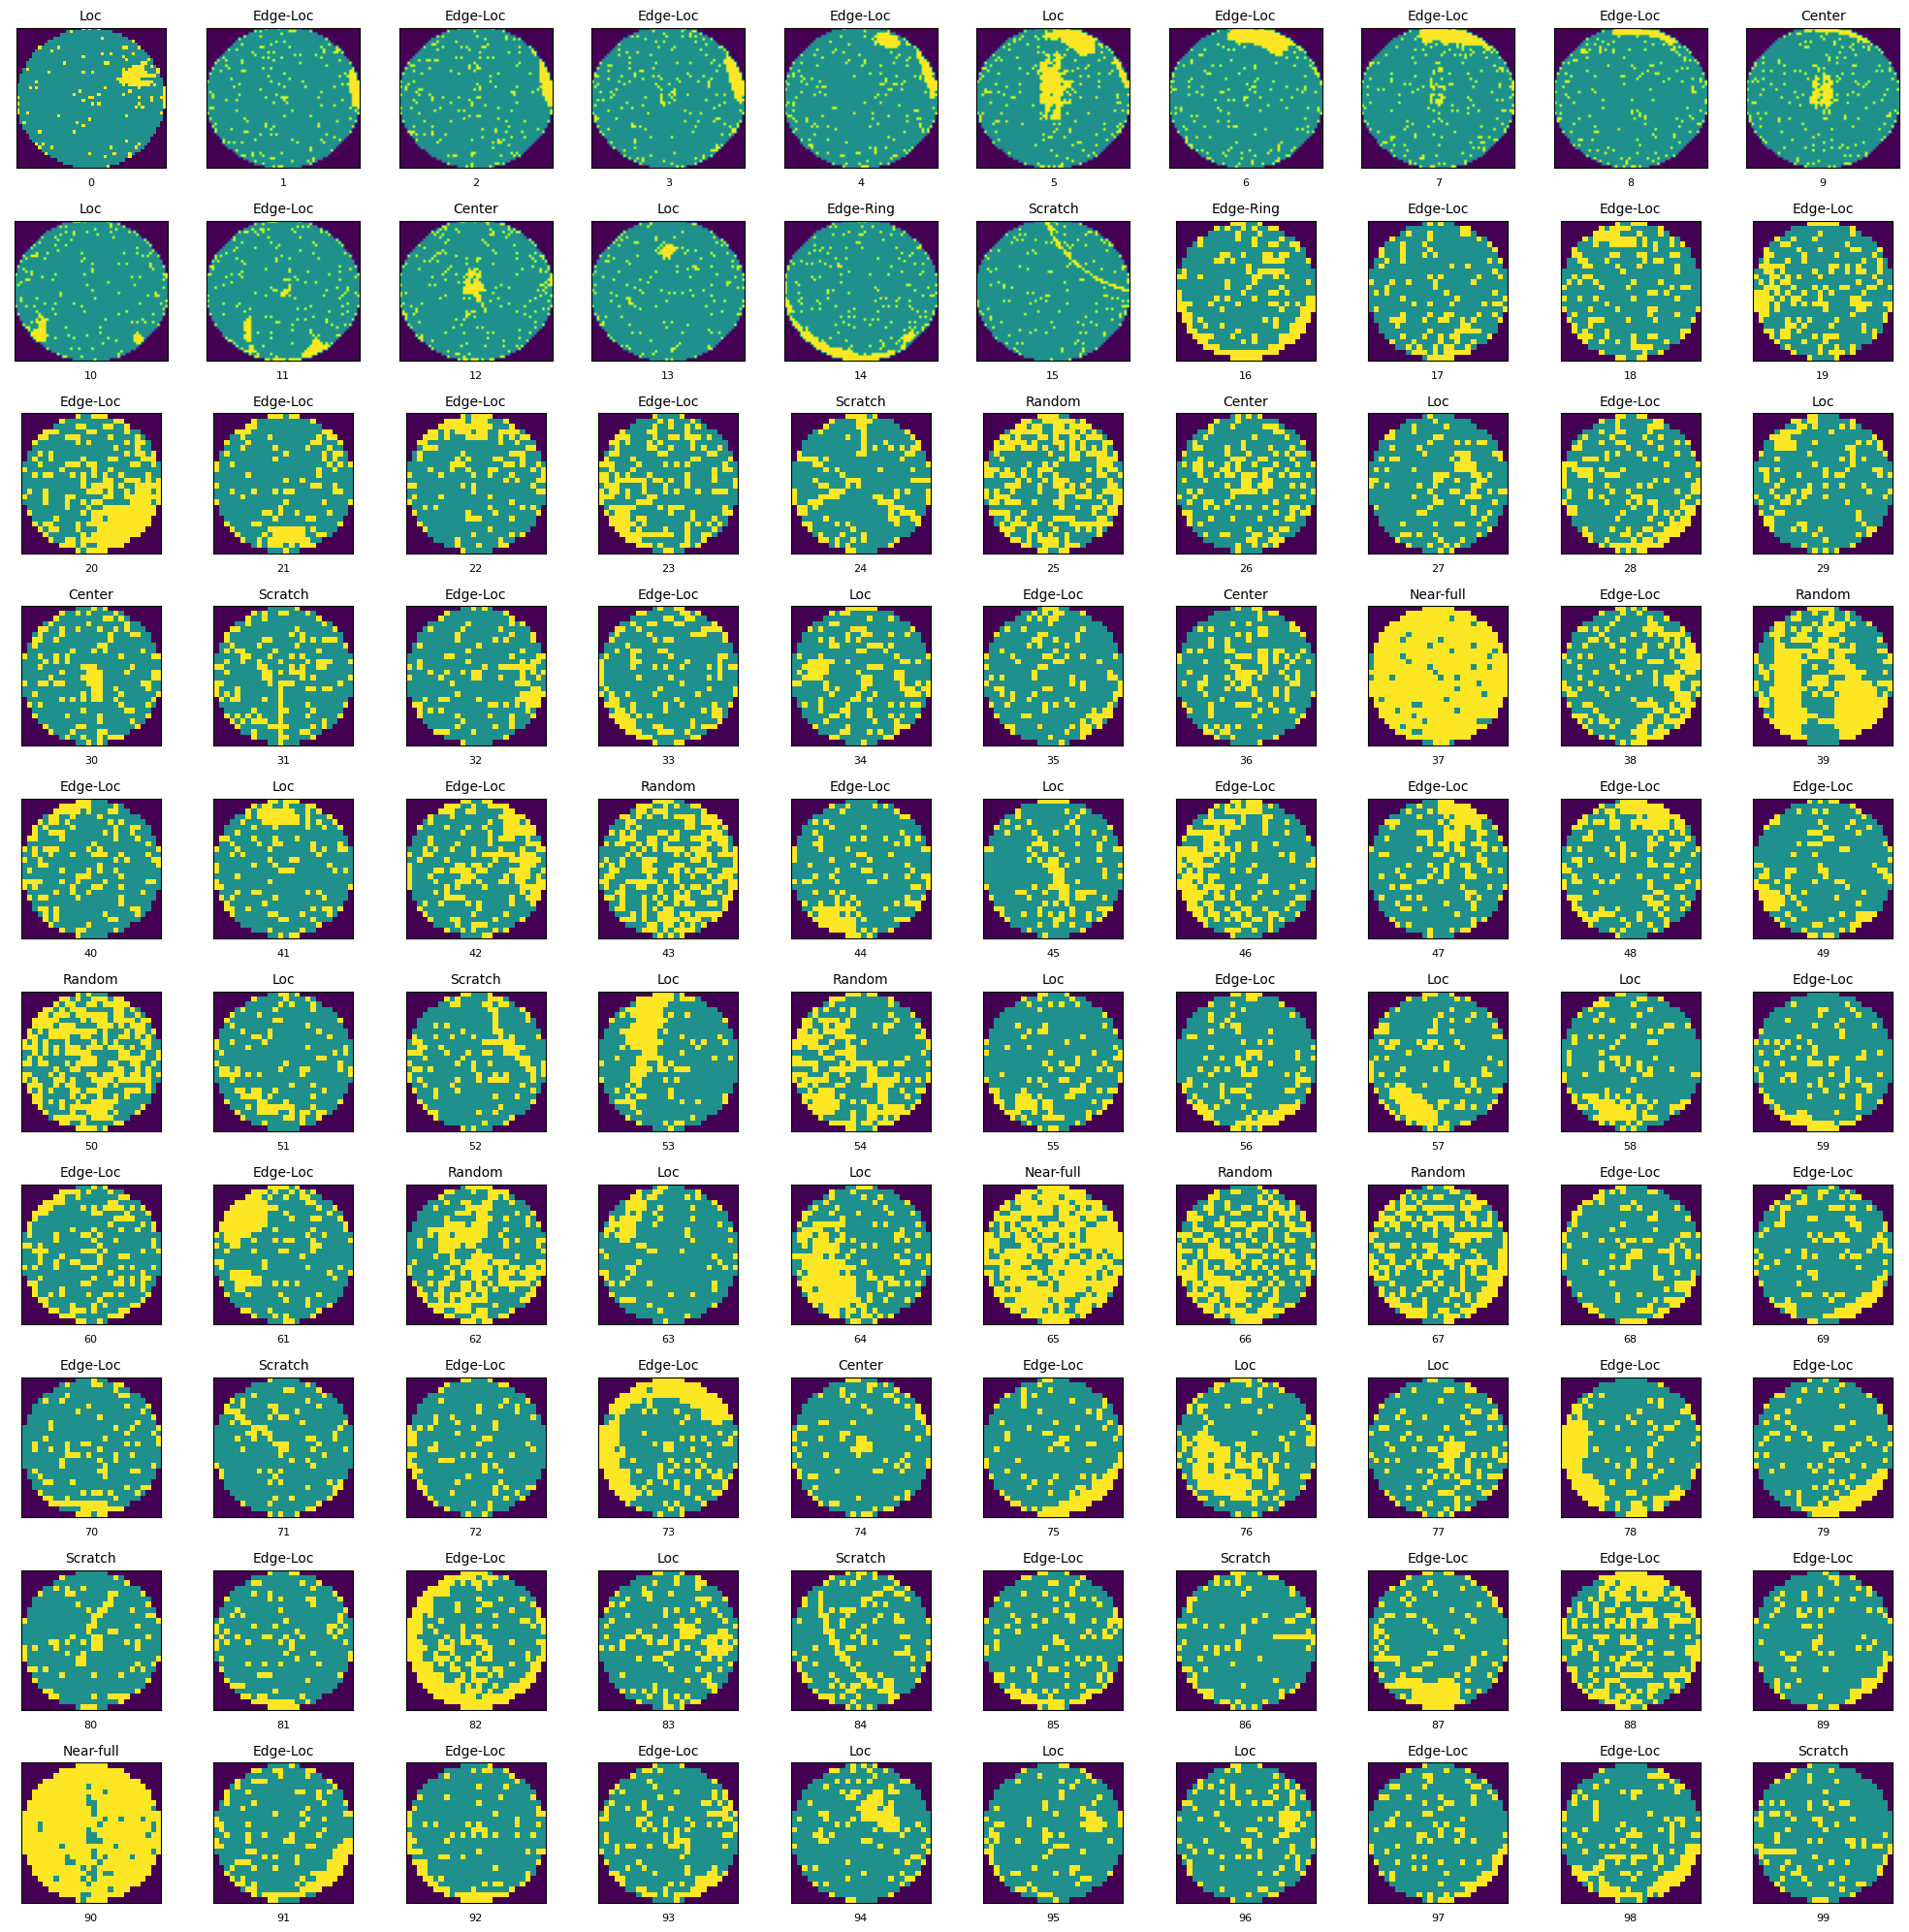

In [16]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_pattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_pattern.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_pattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

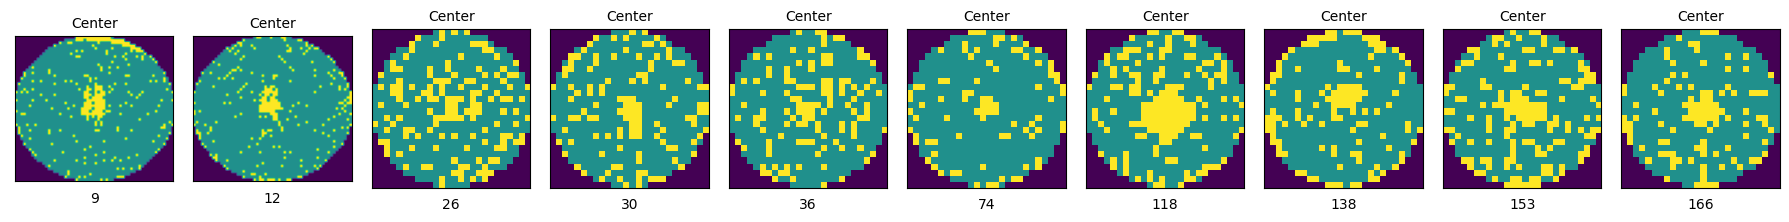

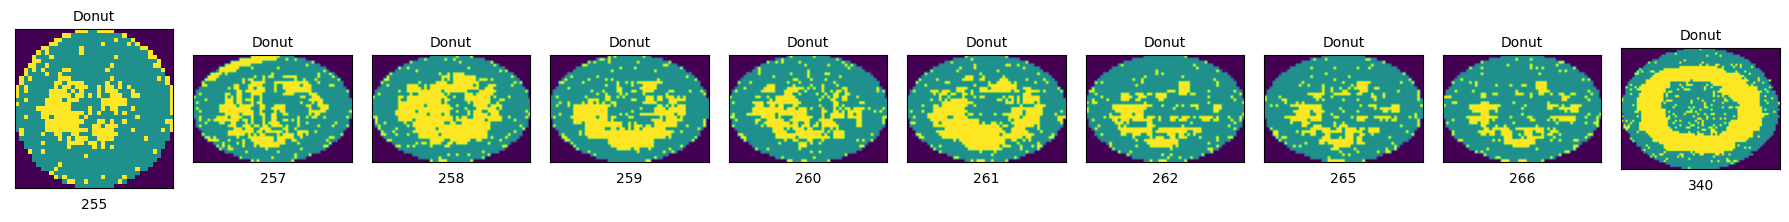

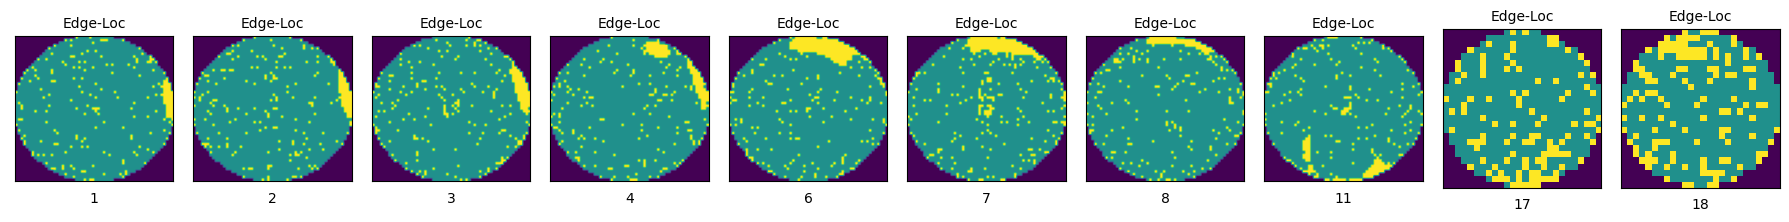

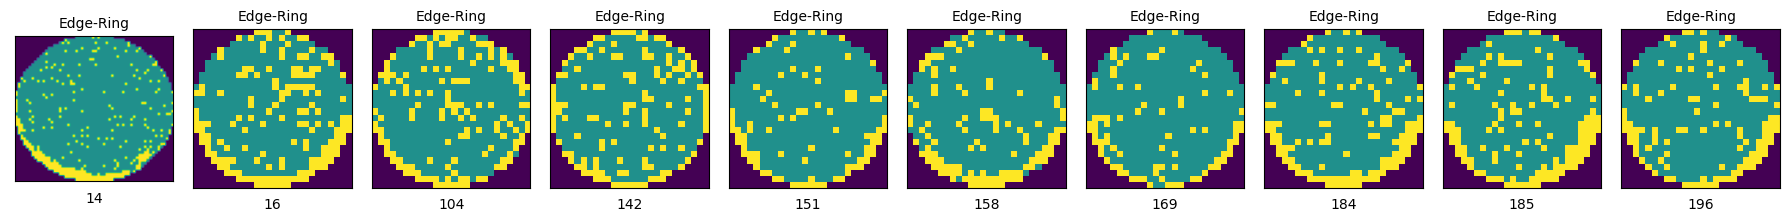

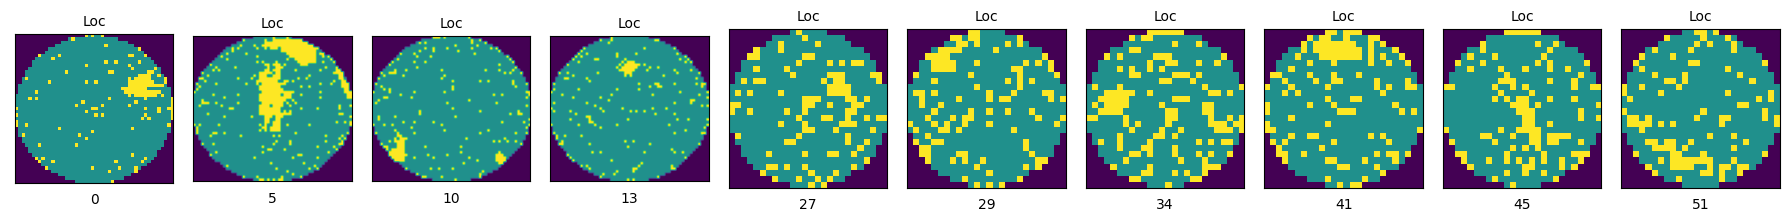

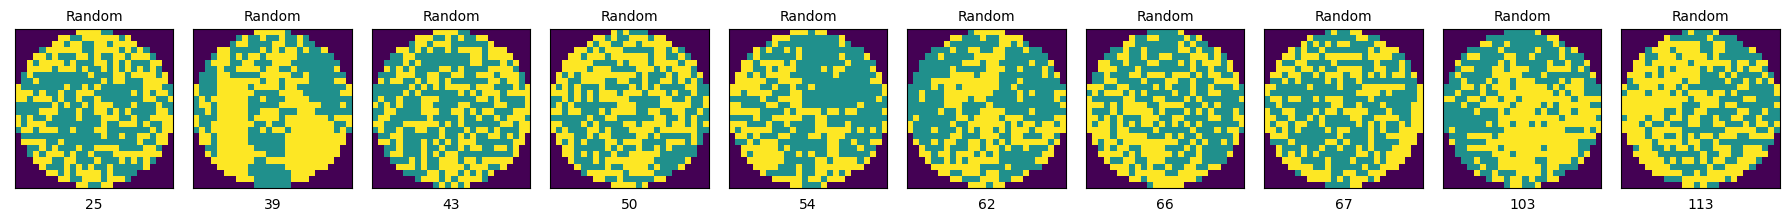

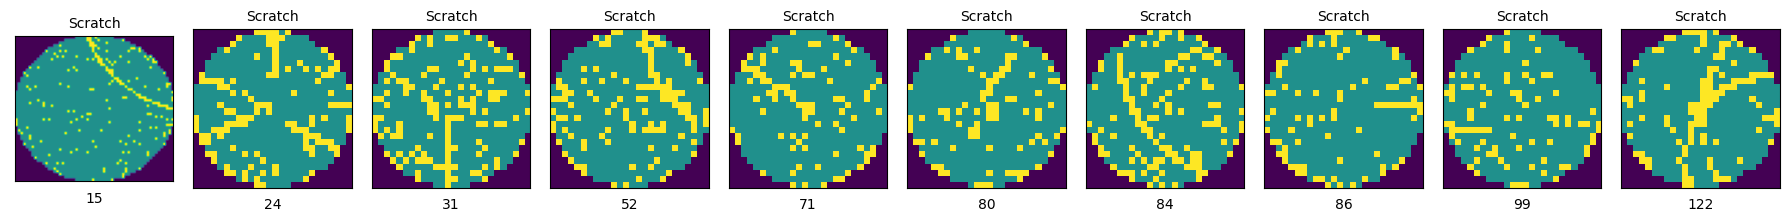

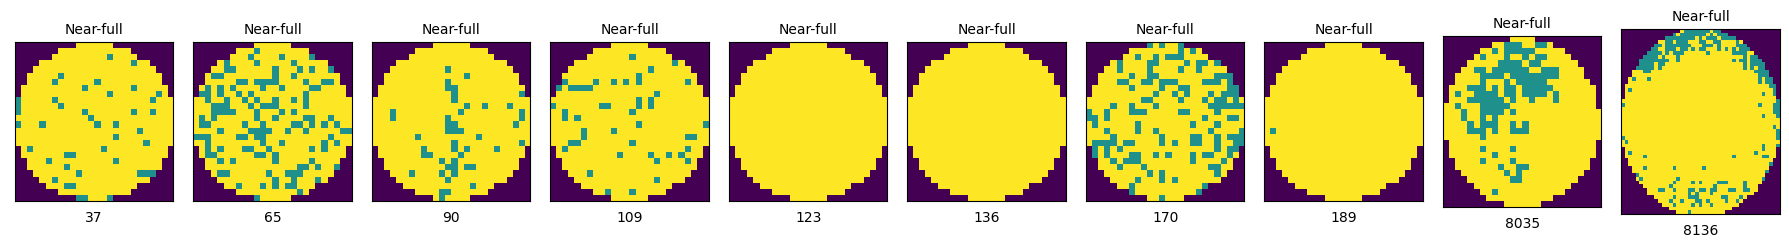

In [17]:
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_pattern.waferMap[df_pattern.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_pattern.failureType[img.index[i]][0][0], fontsize=10)
            ax[i].set_xlabel(df_pattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

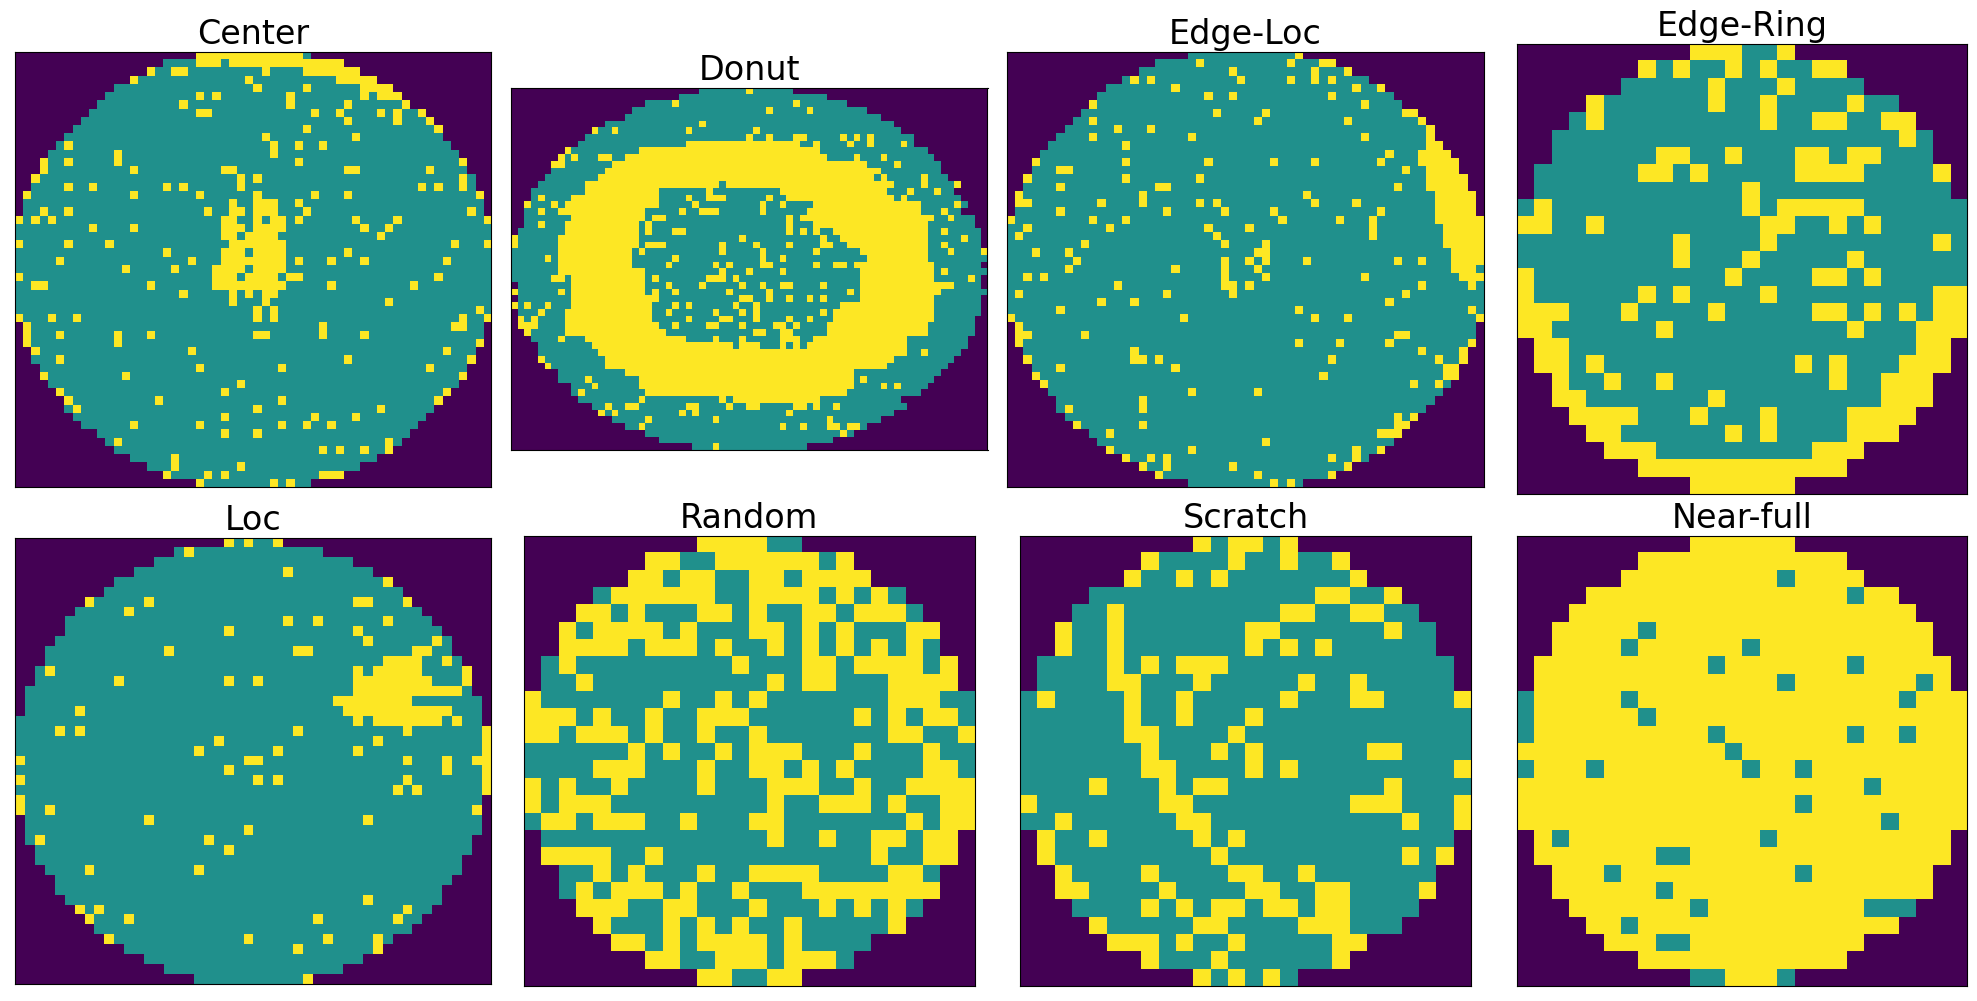

In [18]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_pattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_pattern.failureType[x[i]][0][0],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [19]:
del df
del df_pattern
del df_none

In [20]:
!pip install tensorflow
!pip install keras

Defaulting to user installation because normal site-packages is not writeable
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached cachetools-5.3.0-py3-none-any.whl (9.3 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable


In [21]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPool2D
from tensorflow.keras.layers import Flatten, Softmax, SpatialDropout2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [22]:
model = Sequential([
    # Input
    Input(shape=(224, 224, 3)),
    
    # block 1
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 2
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 3
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 4
    Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    
    # block 5
    SpatialDropout2D(rate=0.2),
    MaxPool2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(9, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 111, 111, 16)     64        
 hNormalization)                                                 
                                                        

In [23]:
import cv2

def reshape_images(images, height, width):
    reshaped_images = np.zeros((len(images), height, width, 3))
    for n in range(len(images)):
        for h in range(height):
            for w in range(width):
                reshaped_images[n, h, w, images[n][h][w]] = 1
    return reshaped_images

def augment_images(images, number=None):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            rotate=(-180, 180),
            shear=(-8, 8)
        ),
    ], random_order=True)
    
    images_input = np.random.choice(images, number) if number else images
    images_expanded = []
    for image in images_input:
        images_expanded.append(image)
    images_expanded = np.array(images_expanded)
    images_augmented = seq(images=images_expanded)
    return images_augmented

In [24]:
import gc
gc.collect()

523

In [27]:
class_num = 9
dsize = (224, 224)
count_per_class_test = 20
count_per_class = 80

x_test, y_test = [], []
for failureNum in range(class_num):
    extracted = df_label[df_label['failureNum'] == failureNum].sample(count_per_class_test, replace=True).waferMap
    resized = extracted.apply(lambda x:cv2.resize(x, dsize=dsize, interpolation=cv2.INTER_AREA))
    del extracted
    augmented = np.array(augment_images(resized))
    reshaped = reshape_images(augmented, dsize[1], dsize[0])
    del augmented

    labels = np.zeros((count_per_class_test, class_num))
    for i in range(count_per_class_test):
        labels[i][failureNum] = 1
        
    x_test.extend(reshaped)
    y_test.extend(labels)
x_test = np.array(x_test)
y_test = np.array(y_test)

histories = []
for j in range(10):
    print(str(j+1) + "번째")
    x_train, y_train = [], []
    for failureNum in range(class_num):
        extracted = df_label[df_label['failureNum'] == failureNum].sample(count_per_class, replace=True).waferMap
        resized = extracted.apply(lambda x:cv2.resize(x, dsize=dsize, interpolation=cv2.INTER_AREA))
        del extracted
        augmented = np.array(augment_images(resized))
        reshaped = reshape_images(augmented, dsize[1], dsize[0])
        del augmented

        labels = np.zeros((count_per_class, class_num))
        for i in range(count_per_class):
            labels[i][failureNum] = 1

        x_train.extend(reshaped)
        y_train.extend(labels)
#     x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.3)
    
    history = model.fit(np.array(x_train), np.array(y_train), validation_data=(x_test, y_test), epochs=20, batch_size=10)
    histories.append(history)

1번째


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

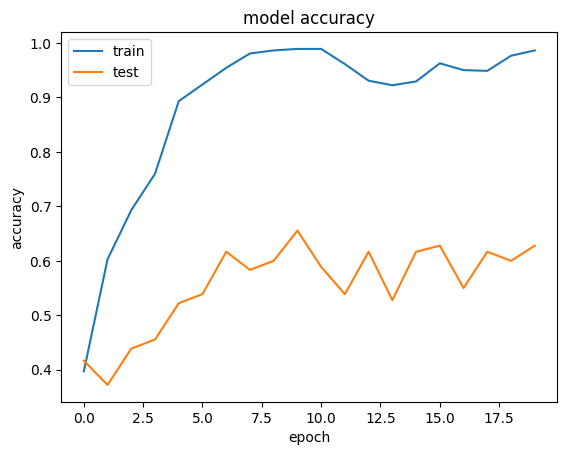

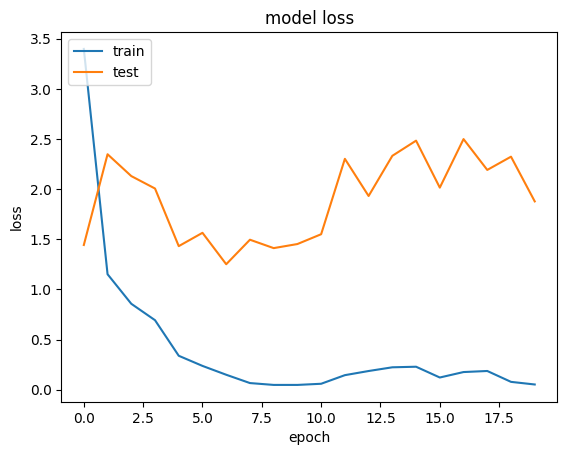

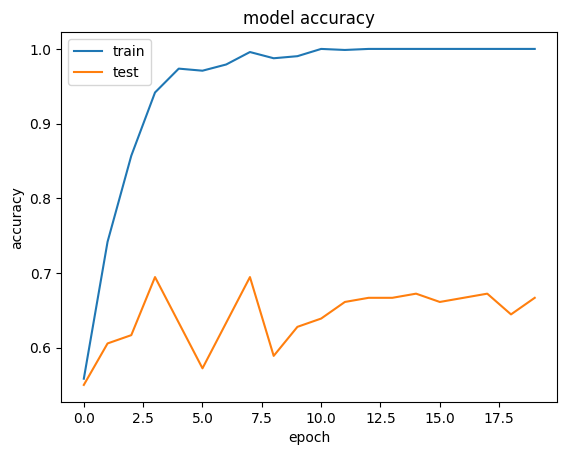

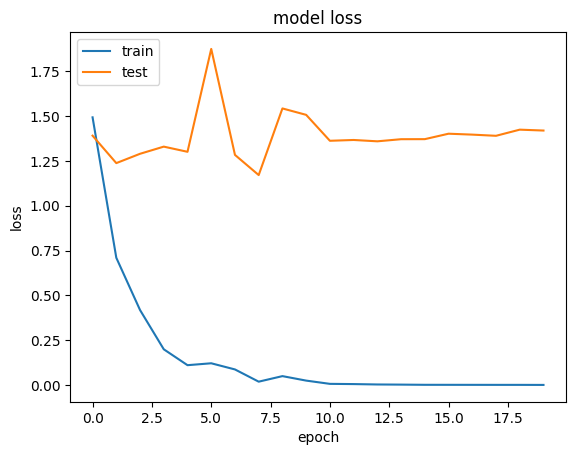

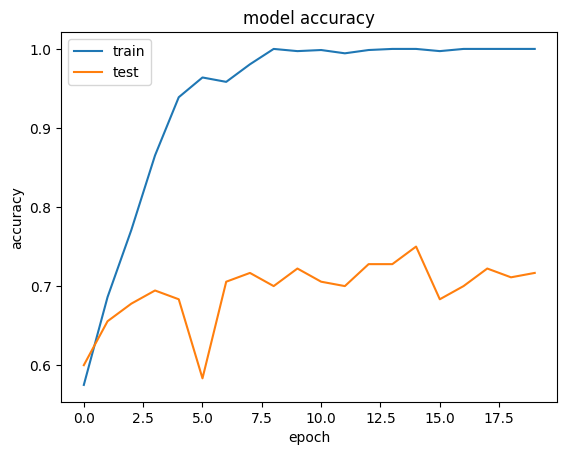

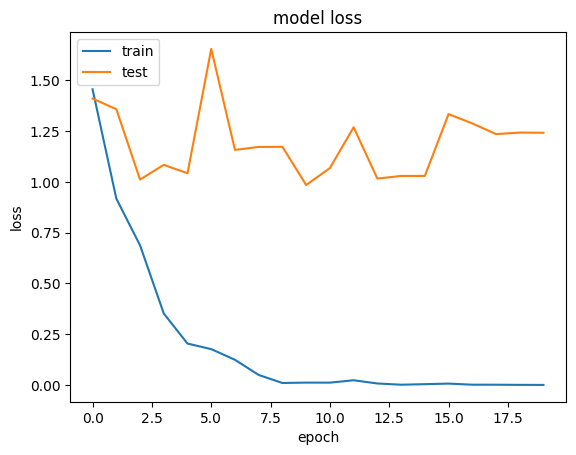

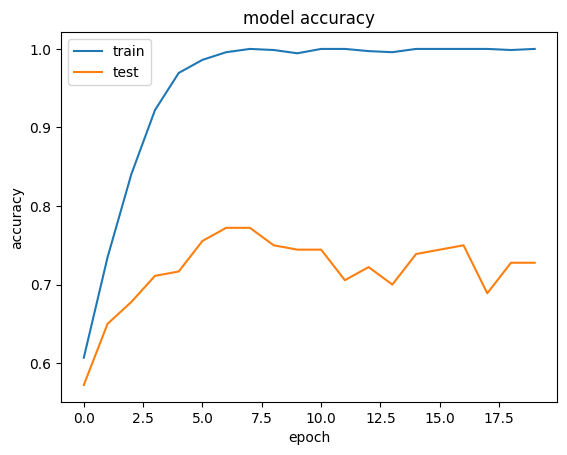

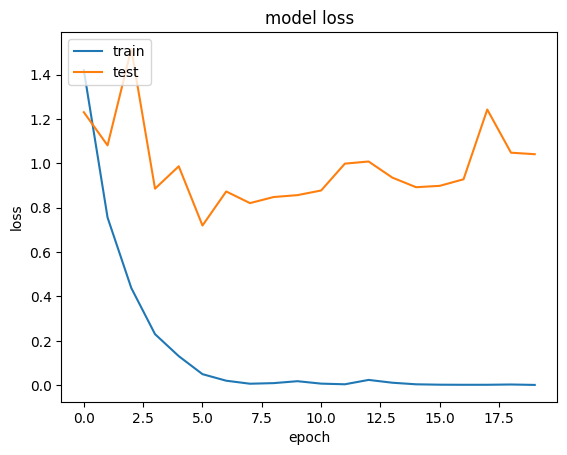

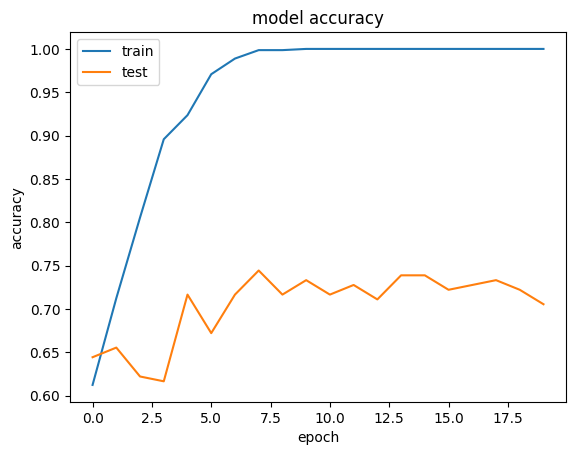

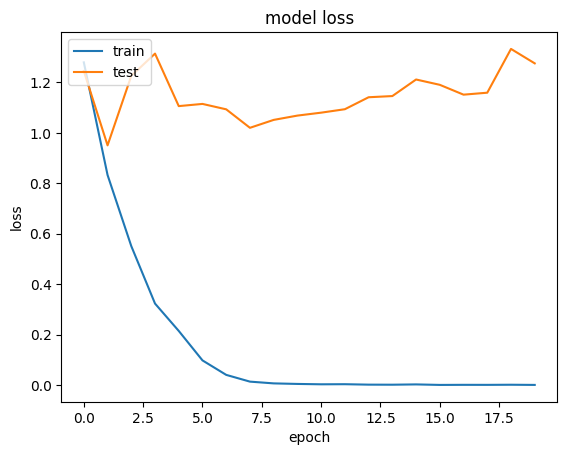

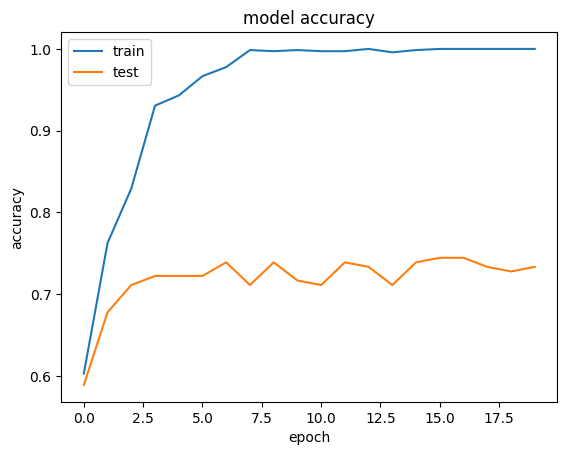

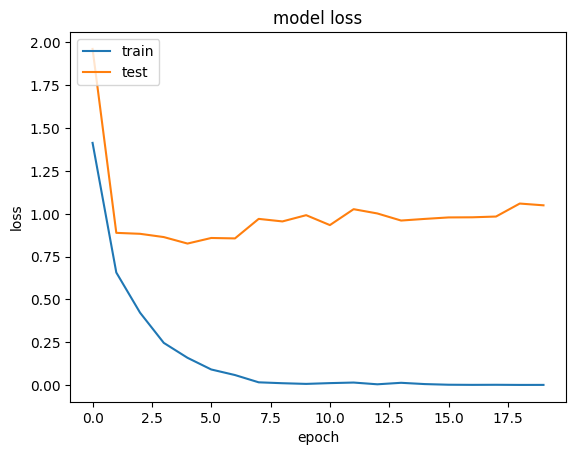

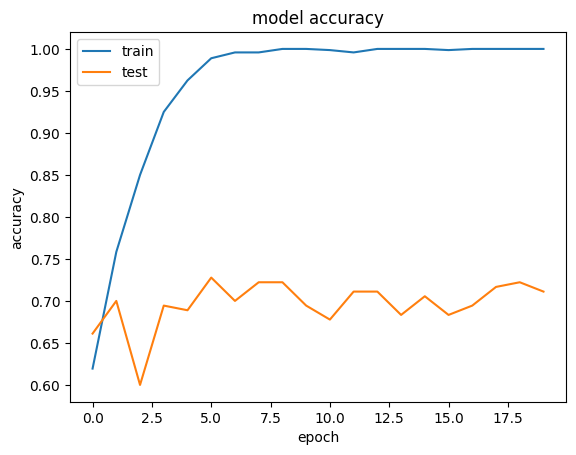

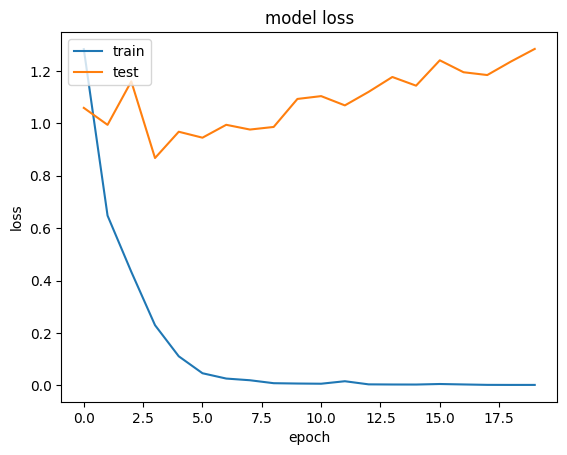

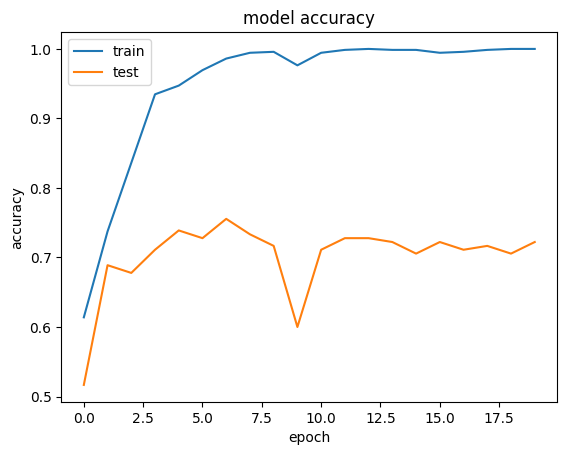

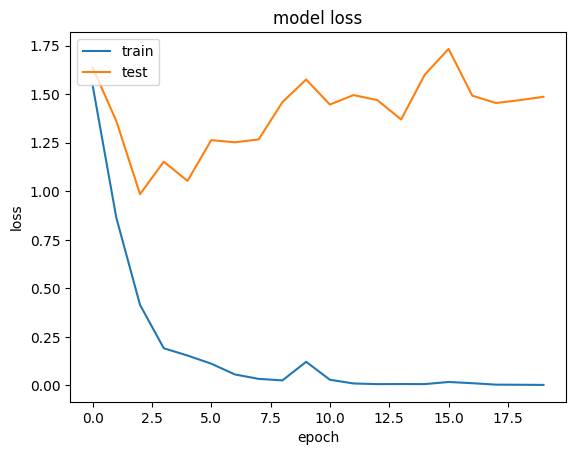

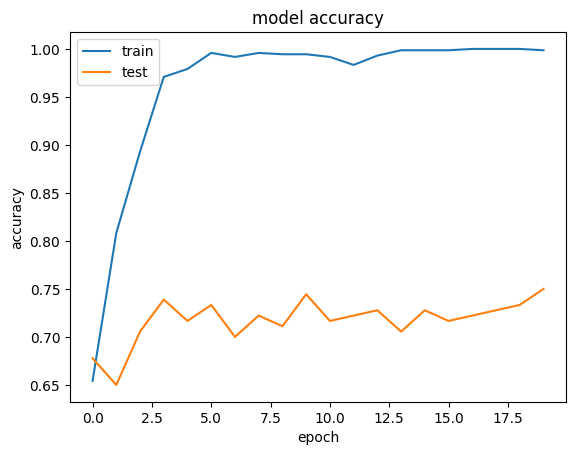

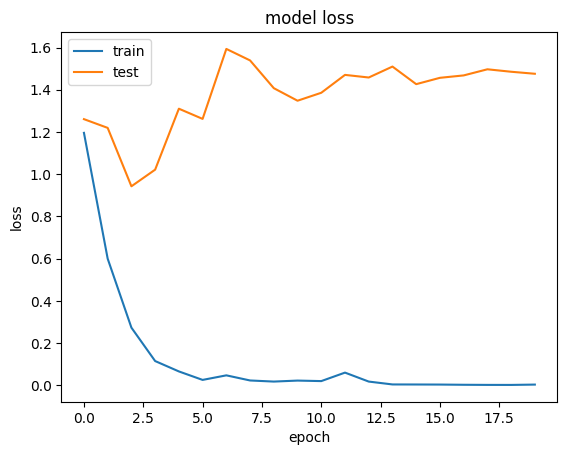

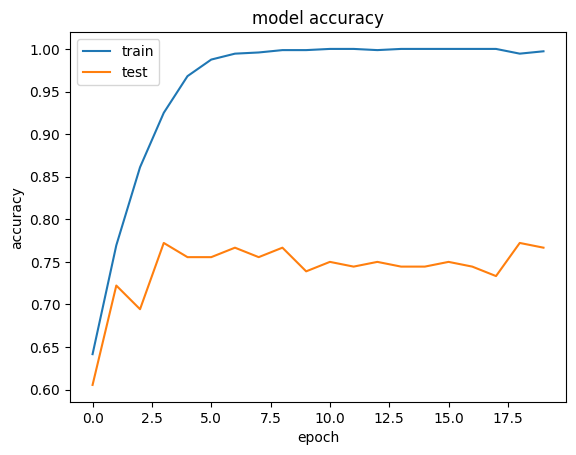

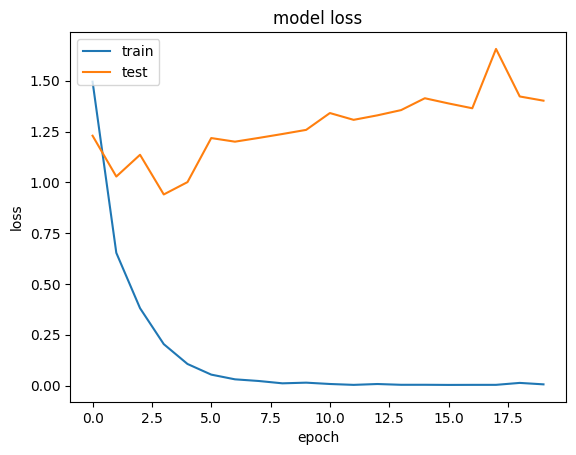

In [ ]:
for history in histories:
    # accuracy plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()